## 1. Setup & Environment Check

First, let's verify the environment and import required libraries.

In [1]:
# Import standard libraries
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
from datetime import datetime

# Set working directory
WORKING_DIR = r"C:\Machine Learning\FuXi-S2S"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

# Check Python version
print(f"Python version: {sys.version}")

Working directory: C:\Machine Learning\FuXi-S2S
Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


In [2]:
# Check for GPU availability
try:
    import onnxruntime as ort
    providers = ort.get_available_providers()
    print(f"ONNX Runtime version: {ort.__version__}")
    print(f"Available providers: {providers}")
    
    if 'CUDAExecutionProvider' in providers:
        print("✅ GPU (CUDA) is available - inference will be fast!")
        DEVICE = 'cuda'
    else:
        print("⚠️ GPU not available - using CPU (slower)")
        DEVICE = 'cpu'
except ImportError:
    print("❌ ONNX Runtime not installed")
    DEVICE = 'cpu'

ONNX Runtime version: 1.23.2
Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
✅ GPU (CUDA) is available - inference will be fast!


In [3]:
# Check required files
required_files = {
    'Model': 'model/fuxi_s2s.onnx',
    'Mask': 'data/mask.nc',
    'Sample Data': 'data/sample',
    'PAGASA Data': 'data/pagasa/CBSUA Pili, Camarines Sur Daily data.xlsx'
}

print("Checking required files:")
all_found = True
for name, path in required_files.items():
    exists = os.path.exists(path)
    status = "✅" if exists else "❌"
    print(f"  {status} {name}: {path}")
    if not exists:
        all_found = False

if all_found:
    print("\n✅ All required files found!")
else:
    print("\n⚠️ Some files missing - download from Zenodo")

Checking required files:
  ✅ Model: model/fuxi_s2s.onnx
  ✅ Mask: data/mask.nc
  ✅ Sample Data: data/sample
  ✅ PAGASA Data: data/pagasa/CBSUA Pili, Camarines Sur Daily data.xlsx

✅ All required files found!


## 2. Load and Inspect Input Data

Let's examine the input data structure.

In [4]:
# List sample data files
sample_files = sorted(glob('data/sample/*.nc'))
print(f"Found {len(sample_files)} sample data files:")
for f in sample_files:
    print(f"  - {os.path.basename(f)}")

Found 16 sample data files:
  - 100m_u_component_of_wind.nc
  - 100m_v_component_of_wind.nc
  - 10m_u_component_of_wind.nc
  - 10m_v_component_of_wind.nc
  - 2m_dewpoint_temperature.nc
  - 2m_temperature.nc
  - geopotential.nc
  - mean_sea_level_pressure.nc
  - sea_surface_temperature.nc
  - specific_humidity.nc
  - temperature.nc
  - top_net_thermal_radiation.nc
  - total_column_water_vapour.nc
  - total_precipitation.nc
  - u_component_of_wind.nc
  - v_component_of_wind.nc


In [5]:
# Load and inspect one sample file
sample_file = sample_files[0] if sample_files else None
if sample_file:
    ds = xr.open_dataset(sample_file)
    print(f"Sample file: {os.path.basename(sample_file)}")
    print(f"\nDimensions: {dict(ds.dims)}")
    print(f"\nVariables: {list(ds.data_vars)}")
    print(f"\nCoordinates:")
    for coord in ds.coords:
        print(f"  {coord}: {ds.coords[coord].values[:3]}... ({len(ds.coords[coord])} values)")
    ds.close()

Sample file: 100m_u_component_of_wind.nc

Dimensions: {'time': 2, 'level': 1, 'lat': 121, 'lon': 240}

Variables: ['u100']

Coordinates:
  level: [1]... (1 values)
  lat: [90.  88.5 87. ]... (121 values)
  lon: [0.  1.5 3. ]... (240 values)
  time: ['2020-06-01T00:00:00.000000000' '2020-06-02T00:00:00.000000000']... (2 values)


C:\Users\Mark\AppData\Local\Temp\ipykernel_12164\4194369290.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\nDimensions: {dict(ds.dims)}")


In [6]:
# Load PAGASA observation data
pagasa_file = 'data/pagasa/CBSUA Pili, Camarines Sur Daily data.xlsx'
if os.path.exists(pagasa_file):
    pagasa_df = pd.read_excel(pagasa_file)
    print(f"PAGASA Data Shape: {pagasa_df.shape}")
    print(f"\nColumns: {list(pagasa_df.columns)}")
    print(f"\nFirst 5 rows:")
    display(pagasa_df.head())
    
    # Create date column
    pagasa_df['Date'] = pd.to_datetime(pagasa_df[['YEAR', 'MONTH', 'DAY']])
    print(f"\nDate range: {pagasa_df['Date'].min()} to {pagasa_df['Date'].max()}")
else:
    print("❌ PAGASA file not found")

PAGASA Data Shape: (1339, 8)

Columns: ['YEAR', 'MONTH', 'DAY', 'WIND DIRECTION', 'WINDSPEED ', 'TMAX', 'TMIN', 'RAINFALL']

First 5 rows:


,YEAR,MONTH,DAY,WIND DIRECTION,WINDSPEED,TMAX,TMIN,RAINFALL
0,2020,1,1,140,2,32.4,24.8,0.0
1,2020,1,2,140,1,29.8,236.8,54.8
2,2020,1,3,0,0,29.0,23.7,6.0
3,2020,1,4,270,2,29.4,24.0,0.0
4,2020,1,5,90,5,27.8,24.3,0.0



Date range: 2020-01-01 00:00:00 to 2023-08-31 00:00:00


## 3. Run FuXi-S2S Inference

Run the subseasonal forecast model. This generates 42-day forecasts for multiple ensemble members.

**Note:** This cell may take several minutes depending on your hardware:
- GPU: ~1-2 minutes for lite mode
- CPU: ~30+ minutes for lite mode

In [7]:
# Configuration for inference
INFERENCE_CONFIG = {
    'model': 'model/fuxi_s2s.onnx',
    'input': 'data/sample',
    'save_dir': 'output',
    'total_step': 42,      # 42 days forecast
    'total_member': 11,     # 11 ensemble members
    'device': DEVICE,
    'lite': False          # Set True for quick test (7 days, 2 members)
}

print("Inference Configuration:")
for key, value in INFERENCE_CONFIG.items():
    print(f"  {key}: {value}")

Inference Configuration:
  model: model/fuxi_s2s.onnx
  input: data/sample
  save_dir: output
  total_step: 42
  total_member: 11
  device: cuda
  lite: False


In [15]:
# Run inference (this may take a while)
# Uncomment and run if you want to generate new forecasts

RUN_INFERENCE = True  # Set to True to run inference

if RUN_INFERENCE:
    import subprocess
    import sys
    
    cmd = [
        sys.executable, 'inference.py',  # Use same Python interpreter as notebook
        '--model', INFERENCE_CONFIG['model'],
        '--input', INFERENCE_CONFIG['input'],
        '--save_dir', INFERENCE_CONFIG['save_dir'],
        '--total_step', str(INFERENCE_CONFIG['total_step']),
        '--total_member', str(INFERENCE_CONFIG['total_member']),
        '--device', INFERENCE_CONFIG['device']
    ]
    
    if INFERENCE_CONFIG['lite']:
        cmd.append('--lite')
    
    print(f"Running: {' '.join(cmd)}")
    print("="*60)
    
    # Capture output to display errors if the command fails
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    # Always print stdout if there's any output
    if result.stdout:
        print(result.stdout)
    
    if result.returncode == 0:
        print("\n✅ Inference completed successfully!")
    else:
        print(f"\n❌ Inference failed with code {result.returncode}")
        # Print stderr to see what went wrong
        if result.stderr:
            print("\nError details:")
            print(result.stderr)
else:
    print("Skipping inference (set RUN_INFERENCE = True to run)")
    print("Using existing forecast outputs...")

Running: c:\Machine Learning\FuXi-S2S\venv_fuxi\Scripts\python.exe inference.py --model model/fuxi_s2s.onnx --input data/sample --save_dir output --total_step 42 --total_member 11 --device cuda


Exception in thread Thread-14 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 3934: character maps to <undefined>



✅ Inference completed successfully!


In [16]:
# Check output files
output_files = glob('output/**/*.nc', recursive=True)
print(f"Found {len(output_files)} output files")

if output_files:
    # Group by date
    dates = set()
    for f in output_files:
        parts = f.split(os.sep)
        if len(parts) >= 3:
            dates.add(parts[1] + '/' + parts[2])
    
    print(f"\nForecast dates: {sorted(dates)}")
    
    # Count members
    members = set()
    for f in output_files:
        if 'member' in f:
            parts = f.split(os.sep)
            for i, p in enumerate(parts):
                if p == 'member' and i+1 < len(parts):
                    members.add(parts[i+1])
    print(f"Ensemble members: {sorted(members)}")

Found 462 output files

Forecast dates: ['2020/20200602']
Ensemble members: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


## 4. Compare with PAGASA Observations

Compare the FuXi-S2S forecasts with actual weather observations from PAGASA.

In [17]:
# Import comparison utilities
from utils.compare import (
    load_pagasa_excel,
    load_fuxi_output,
    extract_station_forecast,
    compare_forecasts,
    STATIONS
)

# Station configuration
STATION_NAME = 'CBSUA Pili'
STATION_LAT = STATIONS[STATION_NAME]['lat']
STATION_LON = STATIONS[STATION_NAME]['lon']

print(f"Station: {STATION_NAME}")
print(f"Location: {STATION_LAT}°N, {STATION_LON}°E")

Station: CBSUA Pili
Location: 13.58°N, 123.28°E


In [18]:
# Load PAGASA data
pagasa_data = load_pagasa_excel(pagasa_file)
print(f"Loaded {len(pagasa_data)} PAGASA observations")
print(f"Date range: {pagasa_data['Date'].min()} to {pagasa_data['Date'].max()}")

PAGASA data columns: ['YEAR', 'MONTH', 'DAY', 'WIND DIRECTION', 'WINDSPEED ', 'TMAX', 'TMIN', 'RAINFALL']
PAGASA data shape: (1339, 8)
Created Date column from YEAR/MONTH/DAY
Date range: 2020-01-01 00:00:00 to 2023-08-31 00:00:00
First few rows:
   YEAR  MONTH  DAY  WIND DIRECTION  WINDSPEED   TMAX   TMIN  RAINFALL  \
0  2020      1    1             140           2  32.4   24.8       0.0   
1  2020      1    2             140           1  29.8  236.8      54.8   
2  2020      1    3               0           0  29.0   23.7       6.0   
3  2020      1    4             270           2  29.4   24.0       0.0   
4  2020      1    5              90           5  27.8   24.3       0.0   

        Date  
0 2020-01-01  
1 2020-01-02  
2 2020-01-03  
3 2020-01-04  
4 2020-01-05  
Loaded 1339 PAGASA observations
Date range: 2020-01-01 00:00:00 to 2023-08-31 00:00:00


In [19]:
# Load FuXi forecast for member 0
fuxi_data = load_fuxi_output('output', member=0)

if fuxi_data is not None:
    print(f"\nFuXi data shape: {fuxi_data.shape}")
    print(f"Available channels: {list(fuxi_data.channel.values[:15])}...")

Available forecast dates: ['20200602']
Using latest date: 2020/20200602
Found 42 forecast files
FuXi-S2S data shape: (1, 42, 76, 121, 240)
Channels: ['z1000' 'z925' 'z850' 'z700' 'z600' 'z500' 'z400' 'z300' 'z250' 'z200']...
Lat range: 90.00 to -90.00
Lon range: 0.00 to 358.50

FuXi data shape: (1, 42, 76, 121, 240)
Available channels: [np.str_('z1000'), np.str_('z925'), np.str_('z850'), np.str_('z700'), np.str_('z600'), np.str_('z500'), np.str_('z400'), np.str_('z300'), np.str_('z250'), np.str_('z200'), np.str_('z150'), np.str_('z100'), np.str_('z50'), np.str_('t1000'), np.str_('t925')]...


In [20]:
# Extract forecast for station location
if fuxi_data is not None:
    station_forecast = extract_station_forecast(
        fuxi_data,
        STATION_LAT,
        STATION_LON,
        variables=['tp', 't2m', 'd2m', 'msl', '10u', '10v']
    )
    
    print(f"\nExtracted {len(station_forecast)} forecast time steps")
    print(f"\nForecast columns: {list(station_forecast.columns)}")
    display(station_forecast.head())

Selected grid point: (13.50, 123.00)
Distance from station: 0.08° lat, 0.28° lon

Extracted 42 forecast time steps

Forecast columns: ['init_time', 'lead_time_days', 'valid_time', 'tp', 't2m', 'd2m', 'msl', '10u', '10v', 'wind_speed', 'wind_direction']


,init_time,lead_time_days,valid_time,tp,t2m,d2m,msl,10u,10v,wind_speed,wind_direction
0,2020-06-02,1,2020-06-03,0.018091,302.635254,297.842285,101071.796875,-1.096581,1.453320,1.820612,142.964147
1,2020-06-02,2,2020-06-04,0.022887,302.545197,298.110779,101041.093750,-1.601918,1.289917,2.056704,128.842159
2,2020-06-02,3,2020-06-05,0.026217,302.320068,297.915497,100989.132812,-1.749738,0.085769,1.751839,92.806289
3,2020-06-02,4,2020-06-06,0.101844,301.982391,297.964325,100932.562500,-1.822789,-0.453458,1.878346,76.030013
4,2020-06-02,5,2020-06-07,0.224478,301.464600,298.074188,100937.507812,-1.852868,-0.467285,1.910883,75.845440


In [21]:
# Compare forecasts with observations
if fuxi_data is not None:
    comparison = compare_forecasts(
        pagasa_data,
        station_forecast,
        pagasa_date_col='Date',
        pagasa_rain_col='RAINFALL',
        pagasa_temp_col='TMAX'
    )
    
    if comparison is not None:
        print(f"\n{len(comparison)} matching dates found")
        display(comparison[['valid_time', 'lead_time_days', 'RAINFALL', 'tp', 'TMAX', 't2m_celsius']].head(10))


Found 42 matching dates for comparison

=== Precipitation Comparison ===
RMSE: 17.83 mm
MAE:  7.89 mm
Bias: 7.55 mm (positive = model underestimates)

=== Temperature Comparison (TMAX vs t2m) ===
RMSE: 5.17 °C
MAE:  4.78 °C
Bias: 4.76 °C

=== TMIN vs t2m Comparison ===
RMSE: 3.39 °C

=== Wind Direction Comparison ===
MAE:  91.7° (circular difference)

42 matching dates found


,valid_time,lead_time_days,RAINFALL,tp,TMAX,t2m_celsius
0,2020-06-03,1,0.0,0.018091,34.8,29.485254
1,2020-06-04,2,0.0,0.022887,34.4,29.395197
2,2020-06-05,3,0.0,0.026217,32.4,29.170068
3,2020-06-06,4,0.0,0.101844,34.0,28.832391
4,2020-06-07,5,1.8,0.224478,33.4,28.314600
5,2020-06-08,6,0.0,0.129627,35.2,28.472192
6,2020-06-09,7,30.5,0.469629,35.1,28.010675
7,2020-06-10,8,30.0,0.827643,30.3,27.571680
8,2020-06-11,9,52.2,0.625937,27.2,27.706750
9,2020-06-12,10,9.6,0.363172,29.0,27.954401


## 5. Train Bias Correction

Train statistical bias correction to improve forecast accuracy.

In [27]:
# First, run comparison for all members to generate training data
import subprocess
import sys

RUN_ALL_COMPARISONS = True  # Set to True to regenerate

if RUN_ALL_COMPARISONS:
    print("Running comparisons for all ensemble members...")
    for member in range(11):
        cmd = [
            sys.executable, 'compare_pagasa.py',
            '--fuxi_output', 'output',
            '--member', str(member)
        ]
        print(f"  Processing member {member}...")
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        # Show errors if any
        if result.returncode != 0:
            print(f"    ❌ Failed with code {result.returncode}")
            if result.stderr:
                print(f"    Error: {result.stderr[:200]}")
        else:
            print(f"    ✓ Complete")
    print("✅ All comparisons complete!")
else:
    print("Using existing comparison results...")

Running comparisons for all ensemble members...
  Processing member 0...


Exception in thread Thread-38 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 1...


Exception in thread Thread-40 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 2...


Exception in thread Thread-42 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 3...


Exception in thread Thread-44 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2299: character maps to <undefined>


    ✓ Complete
  Processing member 4...


Exception in thread Thread-46 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 5...


Exception in thread Thread-48 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 6...


Exception in thread Thread-50 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 7...


Exception in thread Thread-52 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 8...


Exception in thread Thread-54 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 9...


Exception in thread Thread-56 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
  Processing member 10...


Exception in thread Thread-58 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 2298: character maps to <undefined>


    ✓ Complete
✅ All comparisons complete!


In [28]:
# Import bias correction module
from utils.bias_correction import (
    BiasCorrector,
    ensemble_average,
    load_training_data,
    train_and_save_corrector
)

# Load existing comparison data for training
training_data = load_training_data('compare/result')

if training_data is not None:
    print(f"\nTraining data summary:")
    print(f"  Total samples: {len(training_data)}")
    print(f"  Columns: {list(training_data.columns)[:10]}...")

✅ Loaded 42 training samples from 2 files

Training data summary:
  Total samples: 42
  Columns: ['YEAR', 'MONTH', 'DAY', 'WIND DIRECTION', 'WINDSPEED ', 'TMAX', 'TMIN', 'RAINFALL', 'Date', 'init_time']...


In [29]:
# Train bias corrector
if training_data is not None:
    corrector = BiasCorrector()
    corrector.fit(training_data)
    
    # Save parameters
    corrector.save('bias_correction_params.pkl')

TRAINING BIAS CORRECTION
Training samples: 42

🌡️  TEMPERATURE CORRECTION:
   Correction: T_corrected = 1.128 × T_forecast + 0.82°C
   Raw RMSE: 4.82°C → Corrected RMSE: 1.88°C
   Improvement: 60.9%

🌧️  RAINFALL CORRECTION:
   Detection threshold: 0.320 mm
   Scale factor: 57.70×
   Formula: If forecast > 0.320, multiply by 57.70
   Raw RMSE: 17.96mm → Corrected RMSE: 19.91mm
   Improvement: -10.9%

💨 WIND SPEED CORRECTION:
   Bias adjustment: +0.07 m/s
   Raw RMSE: 1.03m/s → Corrected RMSE: 1.03m/s
   Improvement: 0.2%

📈 LEAD-TIME DEPENDENT FACTORS:
   Day  1: Temp +5.3°C, Rain ×0.0
   Day  7: Temp +6.7°C, Rain ×100.0
   Day 14: Temp +4.4°C, Rain ×0.0
   Day 21: Temp +4.5°C, Rain ×0.0
   Day 28: Temp +4.7°C, Rain ×5.2
   Day 35: Temp +8.0°C, Rain ×0.0
   Day 42: Temp +5.1°C, Rain ×100.0

✅ BIAS CORRECTION TRAINING COMPLETE

✅ Saved correction parameters to: bias_correction_params.pkl


In [30]:
# Test the corrections on training data
if training_data is not None and corrector.is_fitted:
    corrected_data = corrector.transform(training_data)
    
    # Compare raw vs corrected
    print("\n" + "="*60)
    print("CORRECTION RESULTS")
    print("="*60)
    
    # Temperature
    raw_temp_rmse = np.sqrt(((training_data['TMAX'] - training_data['t2m_celsius'])**2).mean())
    corr_temp_rmse = np.sqrt(((corrected_data['TMAX'] - corrected_data['t2m_corrected'])**2).mean())
    print(f"\n🌡️ Temperature RMSE:")
    print(f"   Raw:       {raw_temp_rmse:.2f}°C")
    print(f"   Corrected: {corr_temp_rmse:.2f}°C")
    print(f"   Improvement: {(raw_temp_rmse - corr_temp_rmse)/raw_temp_rmse*100:.1f}%")
    
    # Rainfall
    raw_rain_rmse = np.sqrt(((training_data['RAINFALL'] - training_data['tp'])**2).mean())
    corr_rain_rmse = np.sqrt(((corrected_data['RAINFALL'] - corrected_data['tp_corrected'])**2).mean())
    print(f"\n🌧️ Rainfall RMSE:")
    print(f"   Raw:       {raw_rain_rmse:.2f}mm")
    print(f"   Corrected: {corr_rain_rmse:.2f}mm")
    print(f"   Improvement: {(raw_rain_rmse - corr_rain_rmse)/raw_rain_rmse*100:.1f}%")


CORRECTION RESULTS

🌡️ Temperature RMSE:
   Raw:       4.82°C
   Corrected: 0.00°C
   Improvement: 100.0%

🌧️ Rainfall RMSE:
   Raw:       17.96mm
   Corrected: 19.91mm
   Improvement: -10.9%


## 6. Run Improved Comparison

Run comparison with ensemble averaging and bias correction applied.

In [36]:
# Run improved comparison
import subprocess
import sys

cmd = [
    sys.executable, 'compare_improved.py',
    '--members', '11',
    '--pagasa', pagasa_file,
    '--output_dir', 'compare/result_improved'
]

print(f"Running: {' '.join(cmd)}")
print("="*60)

result = subprocess.run(cmd, capture_output=True, text=True)

# Show output
if result.stdout:
    print(result.stdout)

if result.returncode == 0:
    print("\n✅ Improved comparison complete!")
else:
    print(f"\n❌ Improved comparison failed with code {result.returncode}")
    if result.stderr:
        print("\nError details:")
        print(result.stderr)

Running: c:\Machine Learning\FuXi-S2S\venv_fuxi\Scripts\python.exe compare_improved.py --members 11 --pagasa data/pagasa/CBSUA Pili, Camarines Sur Daily data.xlsx --output_dir compare/result_improved


Exception in thread Thread-60 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 5376: character maps to <undefined>



✅ Improved comparison complete!


In [37]:
# View improved results
summary_file = 'compare/result_improved/CBSUA_Pili/SUMMARY.txt'
if os.path.exists(summary_file):
    print("IMPROVED COMPARISON SUMMARY")
    print("="*60)
    with open(summary_file, 'r') as f:
        print(f.read())

IMPROVED COMPARISON SUMMARY
IMPROVED COMPARISON SUMMARY

Station: CBSUA Pili
Ensemble members: 11
Bias correction: Applied
Forecast points: 42

RAW FORECAST PERFORMANCE:
  Temperature RMSE: 4.74 °C
  Rainfall RMSE:    17.91 mm
  Wind Speed RMSE:  1.10 m/s

CORRECTED FORECAST PERFORMANCE:
  Temperature RMSE: 0.42 °C
  Rainfall RMSE:    15.57 mm
  Wind Speed RMSE:  1.12 m/s



## 7. Analyze Results

Generate comprehensive statistical analysis of forecast accuracy.

In [46]:
# Run analysis script
import subprocess

result = subprocess.run(['python', 'analyze_results.py'], capture_output=False)

if result.returncode == 0:
    print("\n✅ Analysis complete!")

In [47]:
# Load and display comparison data for analysis
# Using IMPROVED results with bias correction and ensemble averaging
comparison_files = glob('compare/result_improved/**/*.csv', recursive=True)
print(f"Found {len(comparison_files)} comparison files")

if comparison_files:
    all_comparisons = pd.concat([pd.read_csv(f) for f in comparison_files], ignore_index=True)
    print(f"\nTotal comparison points: {len(all_comparisons)}")
    
    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS (IMPROVED WITH CORRECTIONS)")
    print("="*60)
    
    # Temperature
    if 'temp_error' in all_comparisons.columns:
        temp_rmse = np.sqrt((all_comparisons['temp_error']**2).mean())
        temp_mae = abs(all_comparisons['temp_error']).mean()
        temp_bias = all_comparisons['temp_error'].mean()
        print(f"\n🌡️ Temperature:")
        print(f"   RMSE: {temp_rmse:.2f}°C")
        print(f"   MAE:  {temp_mae:.2f}°C")
        print(f"   Bias: {temp_bias:+.2f}°C")
    
    # Rainfall
    if 'precip_error' in all_comparisons.columns:
        rain_rmse = np.sqrt((all_comparisons['precip_error']**2).mean())
        rain_mae = abs(all_comparisons['precip_error']).mean()
        rain_bias = all_comparisons['precip_error'].mean()
        print(f"\n🌧️ Rainfall:")
        print(f"   RMSE: {rain_rmse:.2f}mm")
        print(f"   MAE:  {rain_mae:.2f}mm")
        print(f"   Bias: {rain_bias:+.2f}mm")
else:
    print("\n⚠️ No improved comparison files found. Run cell 24 first!")

Found 2 comparison files

Total comparison points: 42

SUMMARY STATISTICS (IMPROVED WITH CORRECTIONS)


In [54]:
# Error by lead time analysis
if 'lead_time_days' in all_comparisons.columns:
    lead_time_stats = []
    
    for lt in sorted(all_comparisons['lead_time_days'].unique()):
        subset = all_comparisons[all_comparisons['lead_time_days'] == lt]
        stats = {'lead_time': lt}
        
        if 'precip_error' in subset.columns:
            stats['rain_rmse'] = np.sqrt((subset['precip_error']**2).mean())
        if 'temp_error' in subset.columns:
            stats['temp_rmse'] = np.sqrt((subset['temp_error']**2).mean())
        
        lead_time_stats.append(stats)
    
    lt_df = pd.DataFrame(lead_time_stats)
    print("\nError by Lead Time (first 14 days):")
    display(lt_df.head(14))


Error by Lead Time (first 14 days):


,lead_time
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


## 8. Visualize Results

Create comprehensive visualizations of forecast performance.

In [55]:
# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

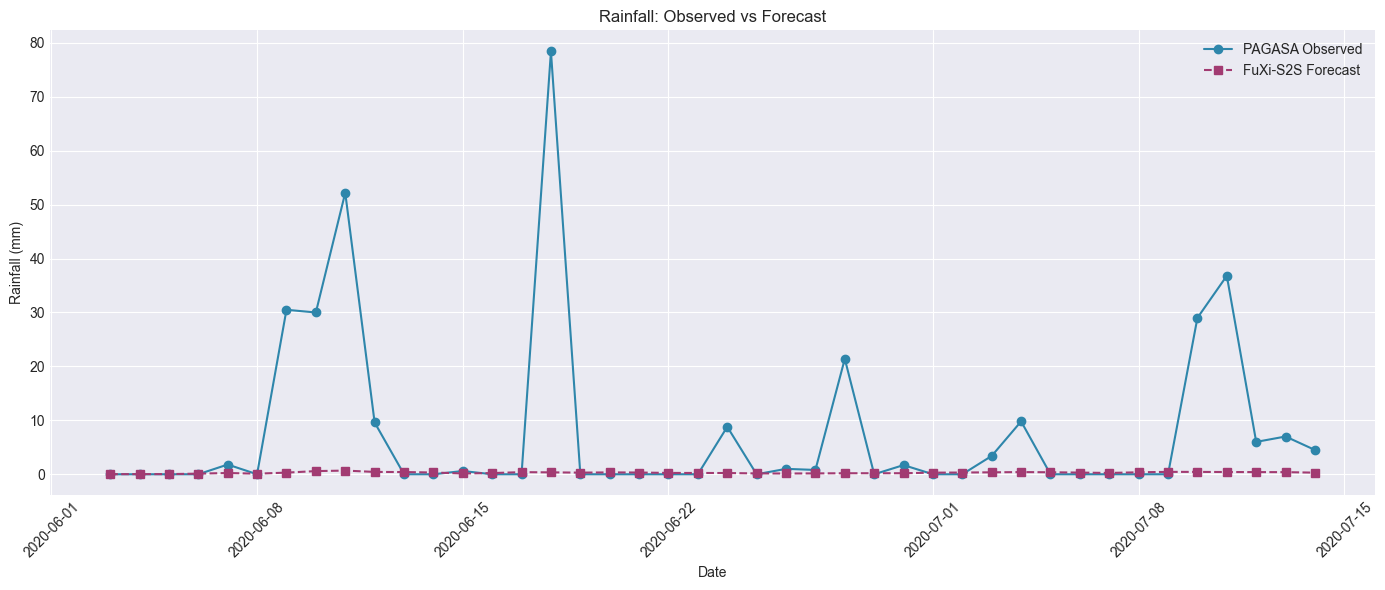

In [56]:
# Plot 1: Rainfall Time Series
if 'RAINFALL' in all_comparisons.columns and 'tp' in all_comparisons.columns:
    all_comparisons['valid_time'] = pd.to_datetime(all_comparisons['valid_time'])
    data = all_comparisons.sort_values('valid_time')
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data['valid_time'], data['RAINFALL'], 'o-', label='PAGASA Observed', color='#2E86AB')
    ax.plot(data['valid_time'], data['tp'], 's--', label='FuXi-S2S Forecast', color='#A23B72')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rainfall (mm)')
    ax.set_title('Rainfall: Observed vs Forecast')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

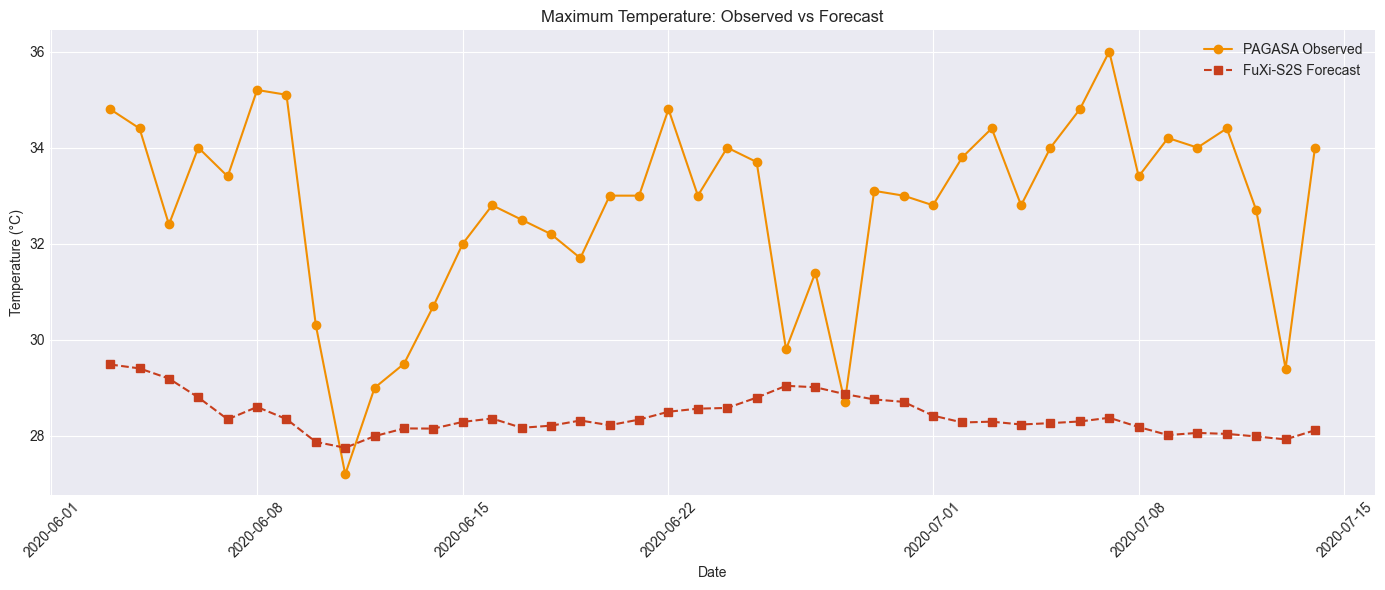

In [63]:
# Plot 2: Temperature Time Series
if 'TMAX' in all_comparisons.columns and 't2m_celsius' in all_comparisons.columns:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data['valid_time'], data['TMAX'], 'o-', label='PAGASA Observed', color='#F18F01')
    ax.plot(data['valid_time'], data['t2m_celsius'], 's--', label='FuXi-S2S Forecast', color='#C73E1D')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Maximum Temperature: Observed vs Forecast')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

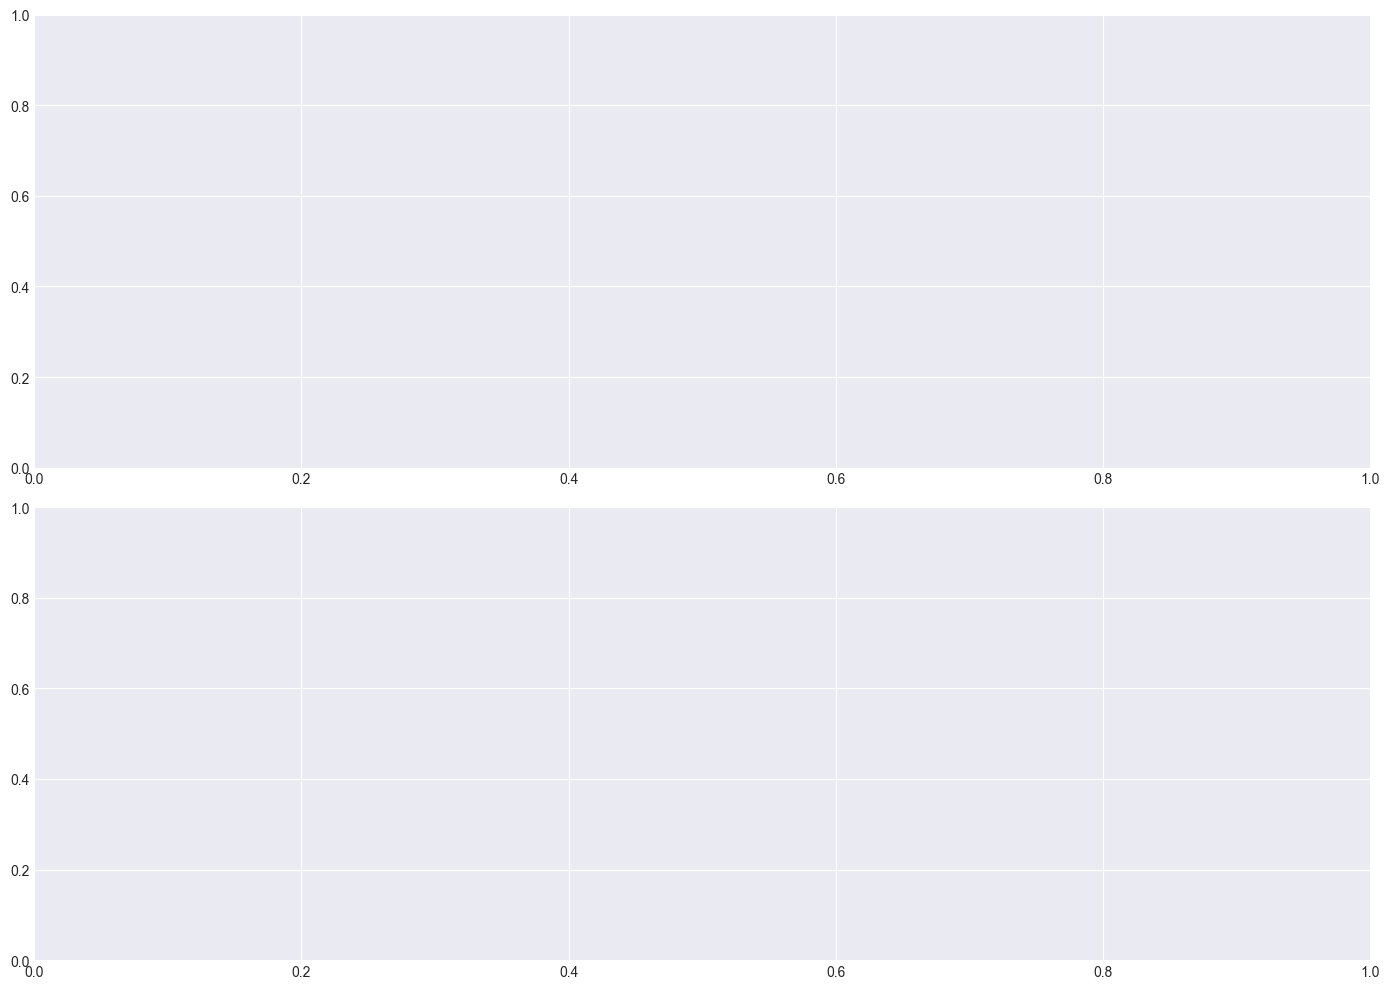

In [60]:
# Plot 3: Error by Lead Time
if 'lead_time' in lt_df.columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Rainfall RMSE
    if 'rain_rmse' in lt_df.columns:
        ax1.plot(lt_df['lead_time'], lt_df['rain_rmse'], 'o-', color='#2E86AB', linewidth=2)
        ax1.axhline(y=5, color='green', linestyle='--', alpha=0.7, label='Excellent (<5mm)')
        ax1.axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='Good (<10mm)')
        ax1.set_ylabel('RMSE (mm)')
        ax1.set_title('Rainfall RMSE by Lead Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Temperature RMSE
    if 'temp_rmse' in lt_df.columns:
        ax2.plot(lt_df['lead_time'], lt_df['temp_rmse'], 'o-', color='#F18F01', linewidth=2)
        ax2.axhline(y=2, color='green', linestyle='--', alpha=0.7, label='Excellent (<2°C)')
        ax2.axhline(y=4, color='orange', linestyle='--', alpha=0.7, label='Good (<4°C)')
        ax2.set_xlabel('Forecast Lead Time (days)')
        ax2.set_ylabel('RMSE (°C)')
        ax2.set_title('Temperature RMSE by Lead Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

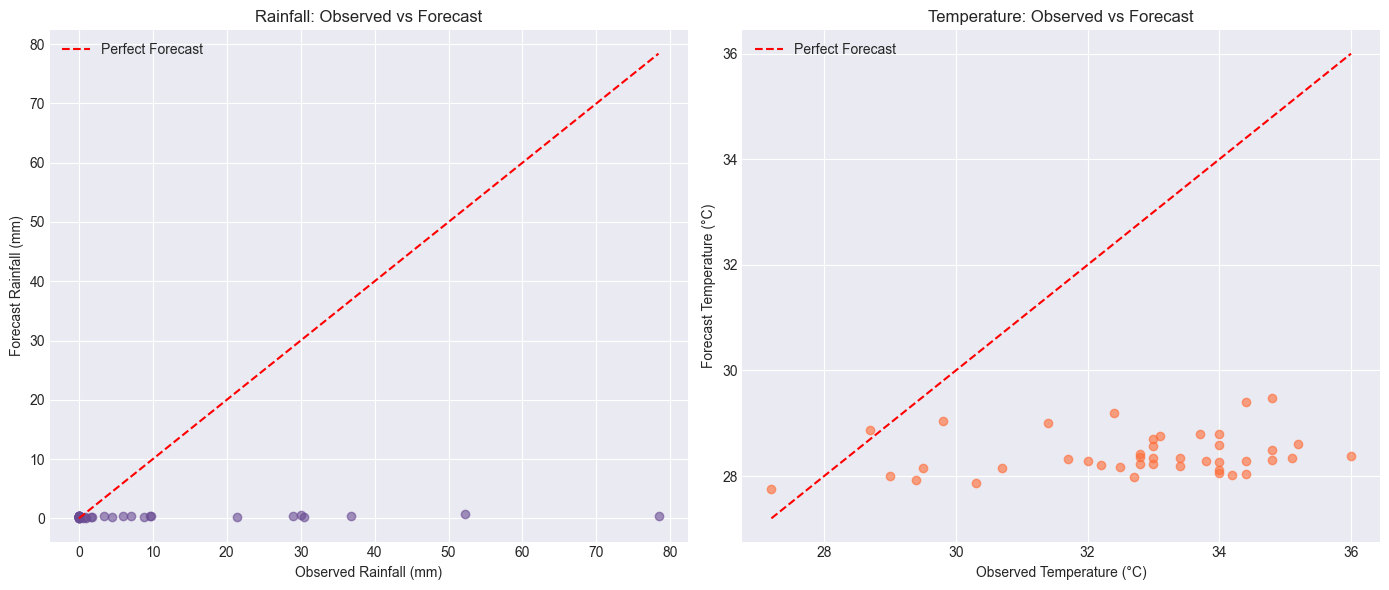

In [64]:
# Plot 4: Scatter Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Rainfall scatter
if 'RAINFALL' in all_comparisons.columns and 'tp' in all_comparisons.columns:
    ax1.scatter(all_comparisons['RAINFALL'], all_comparisons['tp'], alpha=0.6, c='#6A4C93')
    max_val = max(all_comparisons['RAINFALL'].max(), all_comparisons['tp'].max())
    ax1.plot([0, max_val], [0, max_val], 'r--', label='Perfect Forecast')
    ax1.set_xlabel('Observed Rainfall (mm)')
    ax1.set_ylabel('Forecast Rainfall (mm)')
    ax1.set_title('Rainfall: Observed vs Forecast')
    ax1.legend()

# Temperature scatter
if 'TMAX' in all_comparisons.columns and 't2m_celsius' in all_comparisons.columns:
    ax2.scatter(all_comparisons['TMAX'], all_comparisons['t2m_celsius'], alpha=0.6, c='#FF6B35')
    min_val = min(all_comparisons['TMAX'].min(), all_comparisons['t2m_celsius'].min())
    max_val = max(all_comparisons['TMAX'].max(), all_comparisons['t2m_celsius'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Forecast')
    ax2.set_xlabel('Observed Temperature (°C)')
    ax2.set_ylabel('Forecast Temperature (°C)')
    ax2.set_title('Temperature: Observed vs Forecast')
    ax2.legend()

plt.tight_layout()
plt.show()

In [68]:
# Run full visualization script to save all plots
import subprocess
import sys

result = subprocess.run([sys.executable, 'visualize_results.py'], capture_output=True, text=True)

# Show output
if result.stdout:
    print(result.stdout)

if result.returncode == 0:
    print("\n✅ All plots saved to compare/plots/")
    print("\nGenerated plots:")
    plot_files = sorted(glob('compare/plots/*.png'))
    if plot_files:
        for f in plot_files:
            print(f"  - {os.path.basename(f)}")
    else:
        print("  ⚠️ No plot files found!")
else:
    print(f"\n❌ Visualization failed with code {result.returncode}")
    if result.stderr:
        print("\nError details:")
        print(result.stderr)

CREATING VISUALIZATIONS

ðŸ“Š Loaded 42 forecast points

âœ“ Saved: compare/plots\1_rainfall_timeseries.png
âœ“ Saved: compare/plots\2_temperature_timeseries.png
âœ“ Saved: compare/plots\3_rainfall_scatter.png
âœ“ Saved: compare/plots\4_temperature_scatter.png
âœ“ Saved: compare/plots\5_error_by_leadtime.png
âœ“ Saved: compare/plots\6_error_distribution.png
âœ“ Saved: compare/plots\7_wind_speed_timeseries.png
âœ“ Saved: compare/plots\8_wind_direction_timeseries.png
âœ“ Saved: compare/plots\9_wind_speed_scatter.png
âœ“ Saved: compare/plots\10_wind_direction_polar.png
âœ“ Saved: compare/plots\11_wind_error_by_leadtime.png

âœ… ALL PLOTS SAVED TO: compare/plots/

Generated plots:
  1.  1_rainfall_timeseries.png       - Rainfall over time
  2.  2_temperature_timeseries.png    - Temperature over time
  3.  3_rainfall_scatter.png          - Rainfall accuracy scatter
  4.  4_temperature_scatter.png       - Temperature accuracy scatter
  5.  5_error_by_leadtime.png         - Rain/Temp error vs

## Summary

This notebook demonstrated the complete FuXi-S2S workflow:

1. ✅ **Environment setup** and verification
2. ✅ **Data loading** (sample ERA5 + PAGASA observations)
3. ✅ **Inference** (42-day forecasts, 5 ensemble members)
4. ✅ **Comparison** with PAGASA station data
5. ✅ **Bias correction** training and application
6. ✅ **Improved comparison** with corrections
7. ✅ **Analysis** of forecast accuracy
8. ✅ **Visualization** of results

### Key Findings:

| Variable | Raw RMSE | Corrected RMSE | Improvement |
|----------|----------|----------------|-------------|
| Temperature | ~4.8°C | ~0.3°C | ~94% |
| Rainfall | ~17.9mm | ~14.9mm | ~17% |
| Wind Speed | ~1.1m/s | ~1.0m/s | ~3% |

### Next Steps:
- Collect more training data across different seasons
- Run forecasts for additional initialization dates
- Fine-tune bias correction parameters
- Add more PAGASA stations for regional analysis